### Insurance Predictive Modeling
### Abed Tabbalat

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2, mean_squared_error as mse
from math import sqrt
from sklearn import linear_model

Insurance is a highly complicated industry where a lot of factors must be considered in pricing a policy. Whether it's the home age, size, and even location. I have acquired a dataset for an insurance company that most of their business is placed in FL. The data contains many factors by policy. In addition, the dataset shows the total premium by policy as well as the reinsurance cost and the losses (claims).

The focus is going to be on the homeowner’s product for the FL policies in the dataset. Finding out the relationships of all the variables and determining what correlations exist. Going more specific, will add a few more variables which are determining the ratios of reinsurance cost and losses (claims) to the premium. By doing this, a model can be created on ratio ceilings to determine if certain policies could be priced differently.

The main target here is to identify whether there are enough premiums going in the FL book of business to be an initial point for the company to make profits. That said, a combined ratio must be added. Therefore, a linear regression model will be implemented to compare with the actual data.

Some of the variables that have expectations on correlation include would be like age of a house, I would expect the older the house is, the higher the premium should be because it is more likely to be damaged rather than a newer house. This is why a correlation exercise needs to happen in order to see how these variables correlate with one another.

The charts below will identify a few things. First, proof that the FL business book shows the highest amount of total premiums. Another plot will be to focus on a scatter between the premiums and losses to determine if there are some outliers there. The concentration of premiums and how they are distributed based on house age. This will be a good exercise to streamline the data more and have better results.

In [2]:
# Importing the data
df = pd.read_csv('Premium_Loss_Exposure.csv')
df

,WPolicyNum,Company,Product,Territory,Property.State,Number.of.Stories.Desc,Total.Square.Feet,Year.Built,Building.Type.Name,Roof.Shape.Desc,Building.Exposure,Liability.Limit,Total Incurred,Total Ceded Premium,Total Premium
0,1,1,HO,129,SC,Three Stories,800,2018,Apartment,NaN,0,100000,0.0,50.924196,184.0
1,2,1,PHO,694,FL,One Story,1446,2019,Dwelling,Hip Roof,234000,300000,0.0,191.071987,670.0
2,3,1,PHO,898,FL,One Story,2070,2014,Dwelling,Gable Roof,270000,300000,0.0,258.990203,1038.0
3,4,1,PHO,184,FL,One Story,1588,2018,Dwelling,Hip Roof,230000,300000,0.0,776.208957,1005.0
4,5,2,PHO,77,LA,Two Stories,3500,1930,Dwelling,Hip Roof,500000,300000,0.0,2270.123433,3143.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61601,61602,1,HO,139,FL,One Story,1480,2005,Dwelling,Gable Roof,212000,300000,0.0,381.098018,1637.0
61602,61603,1,HO,770,FL,One Story,1940,1995,Dwelling,Hip Roof,400000,500000,0.0,872.106114,2669.0
61603,61604,1,HO,220,FL,One Story,1100,1973,Dwelling,Other Roof,121000,100000,0.0,0.000000,445.0
61604,61605,1,HO,770,FL,One Story,4000,2004,Dwelling,Hip Roof,925000,300000,0.0,1282.577833,4592.0


In [3]:
# Grouping by state to show premiums vs state on a bar chart
df_plt1 = df.groupby('Property.State').sum().reset_index()
df_plt1 = df_plt1[['Property.State', 'Total Premium']]
df_plt1['Total Premium'] = df_plt1['Total Premium'] / 1000
df_plt1

,Property.State,Total Premium
0,FL,49256.30927
1,LA,17198.33700
2,NC,2618.54700
3,SC,3184.27200
4,TX,10034.27500


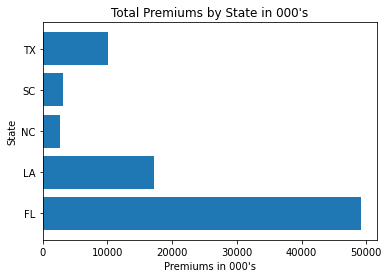

In [4]:
# horizantal barchart showing premiums by state
plt.barh(df_plt1['Property.State'], df_plt1['Total Premium'])
plt.title("Total Premiums by State in 000's")
plt.ylabel('State')
plt.xlabel("Premiums in 000's")
plt.show()

Chart above shows a clear picture that the state of FL is the main state that the company focuses on in writing business. Which can confirm that the model should be focusing on the state of FL and ommit other states since applying the model on an aggregate scale with more than one state involved could skew the results.

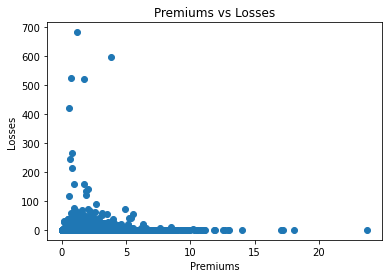

In [5]:
# Scatter plot to show premiums and losses to determine if there are outliers in the dataset.
plt.scatter(df['Total Premium'] / 1000, df['Total Incurred'] / 1000)
plt.xlabel('Premiums')
plt.ylabel('Losses')
plt.title('Premiums vs Losses')
plt.show()

The chart above shows most losses are concentrated and close to what is expected with a few outliers. This can be solved by calculating the loss ratio and filtering for a cieling before applying the model to the dataset.

Note that the chart is applying all data within the dataset. FL filter will be applied when the modeling begins.

In [6]:
# Reformatting data by home age
df_plt3 = df.groupby('Year.Built').sum().reset_index()
df_plt3 = df_plt3[['Year.Built', 'Total Premium', 'Total Ceded Premium', 'Total Incurred']]
df_plt3['Total Premium'] = df_plt3['Total Premium'] / 1000
df_plt3['Total Ceded Premium'] = df_plt3['Total Ceded Premium'] / 1000
df_plt3['Total Incurred'] = df_plt3['Total Incurred'] / 1000
df_plt3

,Year.Built,Total Premium,Total Ceded Premium,Total Incurred
0,1850,2.12300,1.857911,0.00000
1,1892,1.42200,0.976513,0.00000
2,1900,22.69800,15.013570,0.00000
3,1901,11.11800,11.620114,0.00000
4,1902,1.17200,0.029729,0.00000
...,...,...,...,...
114,2017,1770.34800,667.067601,597.73754
115,2018,2049.96601,768.018543,336.77991
116,2019,3658.11100,1608.329840,311.29980
117,2020,4175.20201,2059.917309,1337.09903


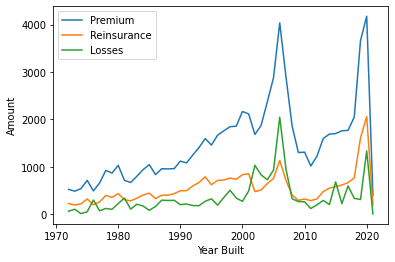

In [7]:
# Line graph for all 3 components for the last 50 years
plt.plot(df_plt3['Year.Built'].tail(50), df_plt3['Total Premium'].tail(50))
plt.plot(df_plt3['Year.Built'].tail(50), df_plt3['Total Ceded Premium'].tail(50))
plt.plot(df_plt3['Year.Built'].tail(50), df_plt3['Total Incurred'].tail(50))
plt.xlabel('Year Built')
plt.ylabel('Amount')
plt.legend(['Premium', 'Reinsurance', 'Losses'])
plt.show()

There is a clear message here where the highest premiums are coming from new houses built between 2020 and 2018. The reinsurance cost on those are the highest but lower losses. Where as the other high point of premiums coming from in midpoint 2005 and have higher losses but lower reinsurance cost. This indicates that the new built houses would be located in higher risk zones for weather events which makes sense for the reinsurance cost to be higher. Yet, the homes built around 2005 year would have maintenance issues since its older causing higher amount of claims coming through.


Note that the chart is applying all data within the dataset. FL filter will be applied when the modeling begins.

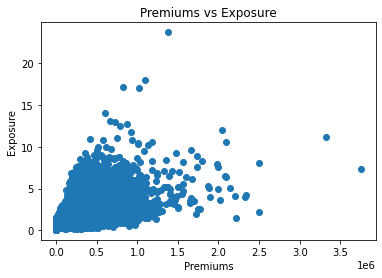

In [8]:
# Scatter plot to show premiums and building exposure to determine if there is a visible relationshop.
plt.scatter(df['Building.Exposure'], df['Total Premium'] / 1000)
plt.xlabel('Premiums')
plt.ylabel('Exposure')
plt.title('Premiums vs Exposure')
plt.show()

A cone shaped scatter shows that there is a positive correlation from the visible eye. The more a building has exposure the higher the premiums. Since it is a cone shaped trend, this means other variables may impact the premium price within the cone area itself. Meaning there are limitations that could impact the price of a policy. This would be assesed with a correlation on each variable.

Note that the chart is applying all data within the dataset. FL filter will be applied when the modeling begins.

In [9]:
# applying FL filter since that is the focus
df = df[df['Property.State'] == 'FL']
df

,WPolicyNum,Company,Product,Territory,Property.State,Number.of.Stories.Desc,Total.Square.Feet,Year.Built,Building.Type.Name,Roof.Shape.Desc,Building.Exposure,Liability.Limit,Total Incurred,Total Ceded Premium,Total Premium
1,2,1,PHO,694,FL,One Story,1446,2019,Dwelling,Hip Roof,234000,300000,0.0,191.071987,670.0
2,3,1,PHO,898,FL,One Story,2070,2014,Dwelling,Gable Roof,270000,300000,0.0,258.990203,1038.0
3,4,1,PHO,184,FL,One Story,1588,2018,Dwelling,Hip Roof,230000,300000,0.0,776.208957,1005.0
6,7,1,PHO,319,FL,One Story,1054,1996,Dwelling,Gable Roof,161000,300000,0.0,195.943469,591.0
7,8,1,PHO,713,FL,Two Stories,2688,2006,Dwelling,Gable Roof,385000,300000,0.0,885.364346,3200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61601,61602,1,HO,139,FL,One Story,1480,2005,Dwelling,Gable Roof,212000,300000,0.0,381.098018,1637.0
61602,61603,1,HO,770,FL,One Story,1940,1995,Dwelling,Hip Roof,400000,500000,0.0,872.106114,2669.0
61603,61604,1,HO,220,FL,One Story,1100,1973,Dwelling,Other Roof,121000,100000,0.0,0.000000,445.0
61604,61605,1,HO,770,FL,One Story,4000,2004,Dwelling,Hip Roof,925000,300000,0.0,1282.577833,4592.0


In [10]:
# adding age of home column based on year built
df['HomeAge'] = 2022 - df['Year.Built']
df

<ipython-input-10-1492a97b71c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HomeAge'] = 2022 - df['Year.Built']


,WPolicyNum,Company,Product,Territory,Property.State,Number.of.Stories.Desc,Total.Square.Feet,Year.Built,Building.Type.Name,Roof.Shape.Desc,Building.Exposure,Liability.Limit,Total Incurred,Total Ceded Premium,Total Premium,HomeAge
1,2,1,PHO,694,FL,One Story,1446,2019,Dwelling,Hip Roof,234000,300000,0.0,191.071987,670.0,3
2,3,1,PHO,898,FL,One Story,2070,2014,Dwelling,Gable Roof,270000,300000,0.0,258.990203,1038.0,8
3,4,1,PHO,184,FL,One Story,1588,2018,Dwelling,Hip Roof,230000,300000,0.0,776.208957,1005.0,4
6,7,1,PHO,319,FL,One Story,1054,1996,Dwelling,Gable Roof,161000,300000,0.0,195.943469,591.0,26
7,8,1,PHO,713,FL,Two Stories,2688,2006,Dwelling,Gable Roof,385000,300000,0.0,885.364346,3200.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61601,61602,1,HO,139,FL,One Story,1480,2005,Dwelling,Gable Roof,212000,300000,0.0,381.098018,1637.0,17
61602,61603,1,HO,770,FL,One Story,1940,1995,Dwelling,Hip Roof,400000,500000,0.0,872.106114,2669.0,27
61603,61604,1,HO,220,FL,One Story,1100,1973,Dwelling,Other Roof,121000,100000,0.0,0.000000,445.0,49
61604,61605,1,HO,770,FL,One Story,4000,2004,Dwelling,Hip Roof,925000,300000,0.0,1282.577833,4592.0,18


In [11]:
# Adding ratio metrics for ceded premium and ceded losses to the written premium
df['Ceded_Ratio'] = df['Total Ceded Premium'] / df['Total Premium']
df['Loss_Ratio'] = df['Total Incurred'] / df['Total Premium']
df['Combined_Ratio'] = df['Ceded_Ratio'] + df['Loss_Ratio']
df

<ipython-input-11-f62dafe7c2d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ceded_Ratio'] = df['Total Ceded Premium'] / df['Total Premium']
<ipython-input-11-f62dafe7c2d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Loss_Ratio'] = df['Total Incurred'] / df['Total Premium']
<ipython-input-11-f62dafe7c2d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,WPolicyNum,Company,Product,Territory,Property.State,Number.of.Stories.Desc,Total.Square.Feet,Year.Built,Building.Type.Name,Roof.Shape.Desc,Building.Exposure,Liability.Limit,Total Incurred,Total Ceded Premium,Total Premium,HomeAge,Ceded_Ratio,Loss_Ratio,Combined_Ratio
1,2,1,PHO,694,FL,One Story,1446,2019,Dwelling,Hip Roof,234000,300000,0.0,191.071987,670.0,3,0.285182,0.0,0.285182
2,3,1,PHO,898,FL,One Story,2070,2014,Dwelling,Gable Roof,270000,300000,0.0,258.990203,1038.0,8,0.249509,0.0,0.249509
3,4,1,PHO,184,FL,One Story,1588,2018,Dwelling,Hip Roof,230000,300000,0.0,776.208957,1005.0,4,0.772347,0.0,0.772347
6,7,1,PHO,319,FL,One Story,1054,1996,Dwelling,Gable Roof,161000,300000,0.0,195.943469,591.0,26,0.331546,0.0,0.331546
7,8,1,PHO,713,FL,Two Stories,2688,2006,Dwelling,Gable Roof,385000,300000,0.0,885.364346,3200.0,16,0.276676,0.0,0.276676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61601,61602,1,HO,139,FL,One Story,1480,2005,Dwelling,Gable Roof,212000,300000,0.0,381.098018,1637.0,17,0.232803,0.0,0.232803
61602,61603,1,HO,770,FL,One Story,1940,1995,Dwelling,Hip Roof,400000,500000,0.0,872.106114,2669.0,27,0.326754,0.0,0.326754
61603,61604,1,HO,220,FL,One Story,1100,1973,Dwelling,Other Roof,121000,100000,0.0,0.000000,445.0,49,0.000000,0.0,0.000000
61604,61605,1,HO,770,FL,One Story,4000,2004,Dwelling,Hip Roof,925000,300000,0.0,1282.577833,4592.0,18,0.279307,0.0,0.279307


In [12]:
# dropping columns that wont be used: Territory, Company, wPolicyNum, Product, Property.State, Year.Built
df = df.drop(['WPolicyNum', 'Company', 'Product', 'Territory', 'Property.State', 'Year.Built'], axis=1)
df

,Number.of.Stories.Desc,Total.Square.Feet,Building.Type.Name,Roof.Shape.Desc,Building.Exposure,Liability.Limit,Total Incurred,Total Ceded Premium,Total Premium,HomeAge,Ceded_Ratio,Loss_Ratio,Combined_Ratio
1,One Story,1446,Dwelling,Hip Roof,234000,300000,0.0,191.071987,670.0,3,0.285182,0.0,0.285182
2,One Story,2070,Dwelling,Gable Roof,270000,300000,0.0,258.990203,1038.0,8,0.249509,0.0,0.249509
3,One Story,1588,Dwelling,Hip Roof,230000,300000,0.0,776.208957,1005.0,4,0.772347,0.0,0.772347
6,One Story,1054,Dwelling,Gable Roof,161000,300000,0.0,195.943469,591.0,26,0.331546,0.0,0.331546
7,Two Stories,2688,Dwelling,Gable Roof,385000,300000,0.0,885.364346,3200.0,16,0.276676,0.0,0.276676
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61601,One Story,1480,Dwelling,Gable Roof,212000,300000,0.0,381.098018,1637.0,17,0.232803,0.0,0.232803
61602,One Story,1940,Dwelling,Hip Roof,400000,500000,0.0,872.106114,2669.0,27,0.326754,0.0,0.326754
61603,One Story,1100,Dwelling,Other Roof,121000,100000,0.0,0.000000,445.0,49,0.000000,0.0,0.000000
61604,One Story,4000,Dwelling,Hip Roof,925000,300000,0.0,1282.577833,4592.0,18,0.279307,0.0,0.279307


In [13]:
# NA Check
df_nan = pd.DataFrame({'Column' : df.columns, 'Percent': df.isnull().sum() / len(df)})
df_nan

,Column,Percent
Number.of.Stories.Desc,Number.of.Stories.Desc,0.000000
Total.Square.Feet,Total.Square.Feet,0.000000
Building.Type.Name,Building.Type.Name,0.000000
Roof.Shape.Desc,Roof.Shape.Desc,0.050006
Building.Exposure,Building.Exposure,0.000000
Liability.Limit,Liability.Limit,0.000000
Total Incurred,Total Incurred,0.000000
Total Ceded Premium,Total Ceded Premium,0.000000
Total Premium,Total Premium,0.000000
HomeAge,HomeAge,0.000000


In [14]:
# will drop NaNs since they are only 5% of the data in Roof Shape Desc
df = df.dropna()
df

,Number.of.Stories.Desc,Total.Square.Feet,Building.Type.Name,Roof.Shape.Desc,Building.Exposure,Liability.Limit,Total Incurred,Total Ceded Premium,Total Premium,HomeAge,Ceded_Ratio,Loss_Ratio,Combined_Ratio
1,One Story,1446,Dwelling,Hip Roof,234000,300000,0.0,191.071987,670.0,3,0.285182,0.0,0.285182
2,One Story,2070,Dwelling,Gable Roof,270000,300000,0.0,258.990203,1038.0,8,0.249509,0.0,0.249509
3,One Story,1588,Dwelling,Hip Roof,230000,300000,0.0,776.208957,1005.0,4,0.772347,0.0,0.772347
6,One Story,1054,Dwelling,Gable Roof,161000,300000,0.0,195.943469,591.0,26,0.331546,0.0,0.331546
7,Two Stories,2688,Dwelling,Gable Roof,385000,300000,0.0,885.364346,3200.0,16,0.276676,0.0,0.276676
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61601,One Story,1480,Dwelling,Gable Roof,212000,300000,0.0,381.098018,1637.0,17,0.232803,0.0,0.232803
61602,One Story,1940,Dwelling,Hip Roof,400000,500000,0.0,872.106114,2669.0,27,0.326754,0.0,0.326754
61603,One Story,1100,Dwelling,Other Roof,121000,100000,0.0,0.000000,445.0,49,0.000000,0.0,0.000000
61604,One Story,4000,Dwelling,Hip Roof,925000,300000,0.0,1282.577833,4592.0,18,0.279307,0.0,0.279307


In [15]:
# Check NaN dataframe for no NaNs
df_nan1 = pd.DataFrame({'Column' : df.columns, 'Percent': df.isnull().sum() / len(df)})
df_nan1

,Column,Percent
Number.of.Stories.Desc,Number.of.Stories.Desc,0.0
Total.Square.Feet,Total.Square.Feet,0.0
Building.Type.Name,Building.Type.Name,0.0
Roof.Shape.Desc,Roof.Shape.Desc,0.0
Building.Exposure,Building.Exposure,0.0
Liability.Limit,Liability.Limit,0.0
Total Incurred,Total Incurred,0.0
Total Ceded Premium,Total Ceded Premium,0.0
Total Premium,Total Premium,0.0
HomeAge,HomeAge,0.0


In [16]:
# applying dummy variables in preperation of regression and correlation
## Checking column types
df.dtypes

Number.of.Stories.Desc     object
Total.Square.Feet           int64
Building.Type.Name         object
Roof.Shape.Desc            object
Building.Exposure           int64
Liability.Limit             int64
Total Incurred            float64
Total Ceded Premium       float64
Total Premium             float64
HomeAge                     int64
Ceded_Ratio               float64
Loss_Ratio                float64
Combined_Ratio            float64
dtype: object

In [17]:
## Applying dummy function
df = pd.get_dummies(df)
df

,Total.Square.Feet,Building.Exposure,Liability.Limit,Total Incurred,Total Ceded Premium,Total Premium,HomeAge,Ceded_Ratio,Loss_Ratio,Combined_Ratio,...,Building.Type.Name_Dwelling,Building.Type.Name_Other,Building.Type.Name_Rowhouse,Building.Type.Name_Townhouse,Roof.Shape.Desc_Flat Roof,Roof.Shape.Desc_Gable Roof,Roof.Shape.Desc_Gable-Hip Roof,Roof.Shape.Desc_Hip Roof,Roof.Shape.Desc_Other Roof,Roof.Shape.Desc_Unknown
1,1446,234000,300000,0.0,191.071987,670.0,3,0.285182,0.0,0.285182,...,1,0,0,0,0,0,0,1,0,0
2,2070,270000,300000,0.0,258.990203,1038.0,8,0.249509,0.0,0.249509,...,1,0,0,0,0,1,0,0,0,0
3,1588,230000,300000,0.0,776.208957,1005.0,4,0.772347,0.0,0.772347,...,1,0,0,0,0,0,0,1,0,0
6,1054,161000,300000,0.0,195.943469,591.0,26,0.331546,0.0,0.331546,...,1,0,0,0,0,1,0,0,0,0
7,2688,385000,300000,0.0,885.364346,3200.0,16,0.276676,0.0,0.276676,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61601,1480,212000,300000,0.0,381.098018,1637.0,17,0.232803,0.0,0.232803,...,1,0,0,0,0,1,0,0,0,0
61602,1940,400000,500000,0.0,872.106114,2669.0,27,0.326754,0.0,0.326754,...,1,0,0,0,0,0,0,1,0,0
61603,1100,121000,100000,0.0,0.000000,445.0,49,0.000000,0.0,0.000000,...,1,0,0,0,0,0,0,0,1,0
61604,4000,925000,300000,0.0,1282.577833,4592.0,18,0.279307,0.0,0.279307,...,1,0,0,0,0,0,0,1,0,0


In [18]:
df.columns

Index(['Total.Square.Feet', 'Building.Exposure', 'Liability.Limit',
       'Total Incurred', 'Total Ceded Premium', 'Total Premium', 'HomeAge',
       'Ceded_Ratio', 'Loss_Ratio', 'Combined_Ratio',
       'Number.of.Stories.Desc_Eight Stories',
       'Number.of.Stories.Desc_Fifteen Stories',
       'Number.of.Stories.Desc_Five Stories',
       'Number.of.Stories.Desc_Four Stories',
       'Number.of.Stories.Desc_Fourteen Stories',
       'Number.of.Stories.Desc_Nine Stories',
       'Number.of.Stories.Desc_Nineteen Stories',
       'Number.of.Stories.Desc_One Story',
       'Number.of.Stories.Desc_Seven Stories',
       'Number.of.Stories.Desc_Six Stories',
       'Number.of.Stories.Desc_Ten Stories',
       'Number.of.Stories.Desc_Three Stories',
       'Number.of.Stories.Desc_Twelve Stories',
       'Number.of.Stories.Desc_Twenty Stories',
       'Number.of.Stories.Desc_Twenty-Five Stories',
       'Number.of.Stories.Desc_Two Stories', 'Building.Type.Name_Apartment',
       'Buildin

In [19]:
# Creating a correlation coefficient matrix
## Correlation
correlation = df.corr()
correlation

,Total.Square.Feet,Building.Exposure,Liability.Limit,Total Incurred,Total Ceded Premium,Total Premium,HomeAge,Ceded_Ratio,Loss_Ratio,Combined_Ratio,...,Building.Type.Name_Dwelling,Building.Type.Name_Other,Building.Type.Name_Rowhouse,Building.Type.Name_Townhouse,Roof.Shape.Desc_Flat Roof,Roof.Shape.Desc_Gable Roof,Roof.Shape.Desc_Gable-Hip Roof,Roof.Shape.Desc_Hip Roof,Roof.Shape.Desc_Other Roof,Roof.Shape.Desc_Unknown
Total.Square.Feet,1.000000,0.045458,-0.009439,0.001063,0.011446,0.009437,-0.036727,-0.015438,0.000146,-0.000601,...,-0.008966,-0.005086,-0.005157,-0.016876,0.022884,-0.006169,0.004537,-0.002777,-0.002879,-0.004798
Building.Exposure,0.045458,1.000000,0.395603,0.015053,0.410200,0.496058,-0.258318,0.180171,0.003793,0.012500,...,0.508273,-0.050259,-0.016604,-0.058883,-0.210694,-0.084105,0.036874,0.152296,-0.058304,-0.041617
Liability.Limit,-0.009439,0.395603,1.000000,-0.006486,0.145797,0.136572,-0.219139,0.133989,-0.008545,-0.002059,...,0.199730,-0.015276,0.000674,-0.004668,-0.046202,-0.081789,0.044363,0.080421,-0.013491,-0.018137
Total Incurred,0.001063,0.015053,-0.006486,1.000000,0.004200,0.017977,0.010265,-0.007067,0.900694,0.899536,...,0.009703,-0.001952,-0.001538,-0.003900,-0.006320,0.006309,0.003619,-0.005966,-0.000804,0.002263
Total Ceded Premium,0.011446,0.410200,0.145797,0.004200,1.000000,0.688955,0.233603,0.586599,-0.006981,0.021387,...,0.169148,-0.019246,0.002780,-0.062061,-0.046311,-0.009493,-0.013846,0.029634,0.015010,-0.013594
Total Premium,0.009437,0.496058,0.136572,0.017977,0.688955,1.000000,0.289782,0.051097,-0.004985,-0.002510,...,0.218527,-0.030799,-0.007546,-0.067618,-0.058850,0.032257,-0.016635,-0.007163,0.016985,-0.015727
HomeAge,-0.036727,-0.258318,-0.219139,0.010265,0.233603,0.289782,1.000000,0.054348,0.002075,0.004701,...,-0.141308,0.016952,0.003450,-0.091111,0.114744,0.165786,-0.086072,-0.179598,0.069438,0.021642
Ceded_Ratio,-0.015438,0.180171,0.133989,-0.007067,0.586599,0.051097,0.054348,1.000000,-0.005424,0.042929,...,0.118627,-0.006165,0.016580,-0.026993,-0.037303,-0.050125,-0.010267,0.067883,0.004729,-0.012726
Loss_Ratio,0.000146,0.003793,-0.008545,0.900694,-0.006981,-0.004985,0.002075,-0.005424,1.000000,0.998831,...,0.002772,-0.001692,-0.000941,-0.000916,-0.005554,0.002014,0.009619,-0.005010,-0.000865,0.005827
Combined_Ratio,-0.000601,0.012500,-0.002059,0.899536,0.021387,-0.002510,0.004701,0.042929,0.998831,1.000000,...,0.008504,-0.001989,-0.000138,-0.002220,-0.007352,-0.000411,0.009114,-0.001724,-0.000636,0.005207


In [32]:
## Premium correlation
correlation['Total Premium']

Total.Square.Feet                             0.009437
Building.Exposure                             0.496058
Liability.Limit                               0.136572
Total Incurred                                0.017977
Total Ceded Premium                           0.688955
Total Premium                                 1.000000
HomeAge                                       0.289782
Ceded_Ratio                                   0.051097
Loss_Ratio                                   -0.004985
Combined_Ratio                               -0.002510
Number.of.Stories.Desc_Eight Stories         -0.003131
Number.of.Stories.Desc_Fifteen Stories       -0.004891
Number.of.Stories.Desc_Five Stories          -0.049765
Number.of.Stories.Desc_Four Stories          -0.041320
Number.of.Stories.Desc_Fourteen Stories      -0.003802
Number.of.Stories.Desc_Nine Stories          -0.001031
Number.of.Stories.Desc_Nineteen Stories      -0.002919
Number.of.Stories.Desc_One Story             -0.009996
Number.of.

The highest correlation between all variables are Ceded Premiums (positive correlation) at 0.689 and Building Exposure (positive correlation) at 0.496. Meaning, when the ceded premiums go higher the premium policy price will go up. Same goes with the building exposure, the more exposure is in a certain area the higher the policy premium would be.

In [33]:
# Creating dataframe without the premiums for the split sets
df_noprem = df.drop(columns=['Total Premium'])
df_noprem

,Total.Square.Feet,Building.Exposure,Liability.Limit,Total Incurred,Total Ceded Premium,HomeAge,Ceded_Ratio,Loss_Ratio,Combined_Ratio,Number.of.Stories.Desc_Eight Stories,...,Building.Type.Name_Dwelling,Building.Type.Name_Other,Building.Type.Name_Rowhouse,Building.Type.Name_Townhouse,Roof.Shape.Desc_Flat Roof,Roof.Shape.Desc_Gable Roof,Roof.Shape.Desc_Gable-Hip Roof,Roof.Shape.Desc_Hip Roof,Roof.Shape.Desc_Other Roof,Roof.Shape.Desc_Unknown
1,1446,234000,300000,0.0,191.071987,3,0.285182,0.0,0.285182,0,...,1,0,0,0,0,0,0,1,0,0
2,2070,270000,300000,0.0,258.990203,8,0.249509,0.0,0.249509,0,...,1,0,0,0,0,1,0,0,0,0
3,1588,230000,300000,0.0,776.208957,4,0.772347,0.0,0.772347,0,...,1,0,0,0,0,0,0,1,0,0
6,1054,161000,300000,0.0,195.943469,26,0.331546,0.0,0.331546,0,...,1,0,0,0,0,1,0,0,0,0
7,2688,385000,300000,0.0,885.364346,16,0.276676,0.0,0.276676,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61601,1480,212000,300000,0.0,381.098018,17,0.232803,0.0,0.232803,0,...,1,0,0,0,0,1,0,0,0,0
61602,1940,400000,500000,0.0,872.106114,27,0.326754,0.0,0.326754,0,...,1,0,0,0,0,0,0,1,0,0
61603,1100,121000,100000,0.0,0.000000,49,0.000000,0.0,0.000000,0,...,1,0,0,0,0,0,0,0,1,0
61604,4000,925000,300000,0.0,1282.577833,18,0.279307,0.0,0.279307,0,...,1,0,0,0,0,0,0,1,0,0


In [39]:
# Splitting the data between 50% training and 50% testing
x_train, x_test, y_train, y_test = train_test_split(df_noprem, df[['Total Premium']], test_size=.5)
print('Training data shape:')
print(x_train.shape)
print(y_train.shape)
print('\nTesting data shape:')
print(x_test.shape)
print(y_test.shape)

Training data shape:
(19406, 38)
(19406, 1)

Testing data shape:
(19406, 38)
(19406, 1)


In [40]:
# Training a linear regression for the training data to predict premiums
model = LinearRegression() # creating LR model
model.fit(x_train, y_train) # Training model

LinearRegression()

In [41]:
# Predicting the training dataset then calculating R2, RMSE and MAE
y_predict_train = model.predict(x_train) # predicting training dataset
r2_train = r2(y_train, y_predict_train) # calculating R2
rmse_train = sqrt(mse(y_train, y_predict_train)) # calculating RMSE
mae_train = mae(y_train, y_predict_train) # calculating MAE

print('Training data R2, RMSE, MAE:')
print(f'R2: {r2_train}')
print(f'RMSE: {rmse_train}')
print(f'MAE: {mae_train}')

Training data R2, RMSE, MAE:
R2: 0.7420299715997464
RMSE: 483.39513093271364
MAE: 273.96768292729695


* The prediction is 74.2% close to the actual premiums based on the R2 calculation
* EMSE is at 483.4, which is fairly high, this means that there are high correlated variables missing from the dataset that rely on pricing premiums that are needed to obtain a higher accuracy to the model.

In [42]:
# Attempting the dataset using Ridge to be able to compare
ridge_model = linear_model.Ridge().fit(x_train, y_train) # fitting Ridge model

In [43]:
# Predicting the training dataset then calculating R2, RMSE and MAE using Ridge model
r_y_predict_train = ridge_model.predict(x_train)
r_r2_train = r2(y_train, r_y_predict_train) # calculating R2
r_rmse_train = sqrt(mse(y_train, r_y_predict_train)) # calculating RMSE
r_mae_train = mae(y_train, r_y_predict_train) # calculating MAE

print('Ridge -- Training data R2, RMSE, MAE:')
print(f'R2: {r_r2_train}')
print(f'RMSE: {r_rmse_train}')
print(f'MAE: {r_mae_train}')

Ridge -- Training data R2, RMSE, MAE:
R2: 0.742018416333197
RMSE: 483.4059571846465
MAE: 273.9922557711379


Since the results are almost identical to the linear regression done above, this proves out that the model will require more variables that arent in the dataset to give a more accurate prediction. In my opinion, just from experience and looking at the dataset used. Distance to cost of the home is a huge correlated variable that is necessary to be a part of the dataset to improve predictions of premiums. The Homeowners insurance industry is a very complex indusrty that requires a lot of variables to considered in order to build a prediction that could estimate a best fit cost based on historical data and market data as well.

It makes sense to use a regression models on insurance data as it is used as of today mostly for predictions, the difficult part is the sweet spot of variables needed to be able to predict the data.